<a href="https://colab.research.google.com/github/lanej5/mlb/blob/main/elo/ELO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook setup


In [1]:
# save for next time
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

Mounted at /content/drive


# Load data

In [49]:
# records of individual teams for each season have been scraped and stored
# let's load 'em up
from os import listdir
from os.path import isfile, join
path = "/content/drive/My Drive/mlb/previous_seasons/"
filenames = [f for f in listdir(path) if isfile(join(path, f))]
data = {}

for filename in filenames:
    year, team = int(filename[:4]), filename[5: 8]
    data[(year, team)] = pd.read_parquet(path + filename)

# prepare data

In [10]:
# take a peek at the data
data[(1990, 'BAL')].head()

,Date,Tm,Home_Away,Opp,W/L,R,RA,Inn,W-L,Rank,GB,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled
1,"Monday, Apr 9",BAL,@,KCR,W,7.0,6.0,11.0,1-0,1.0,Tied,Aldrich,Montgomery,Olson,3:31,D,37671.0,1.25,1,None
2,"Wednesday, Apr 11",BAL,@,KCR,L,1.0,2.0,9.0,1-1,2.0,1.5,Gubicza,Ballard,Davis,2:51,N,18892.0,1.30,-1,None
3,"Friday, Apr 13",BAL,@,DET,L,6.0,10.0,9.0,1-2,5.0,1.5,Morris,Price,None,3:25,N,11871.0,1.45,-2,None
4,"Saturday, Apr 14",BAL,@,DET,W,7.0,4.0,9.0,2-2,3.0,1.0,Johnson,Ritz,Olson,3:36,D,11294.0,1.31,1,None
5,"Sunday, Apr 15",BAL,@,DET,L,4.0,6.0,9.0,2-3,4.0,1.5,Petry,Aldrich,Henneman,3:03,D,10632.0,1.53,-1,None


In [11]:
data[(1990, 'BAL')].dtypes

Date                object
Tm                  object
Home_Away           object
Opp                 object
W/L                 object
R                  float64
RA                 float64
Inn                float64
W-L                 object
Rank               float64
GB                  object
Win                 object
Loss                object
Save                object
Time                object
D/N                 object
Attendance         float64
cLI                 object
Streak               int64
Orig. Scheduled     object
dtype: object

In [50]:
# clean the dates
from datetime import datetime
from calendar import month_abbr

months = {abbr: i + 1 for i, abbr in enumerate(month_abbr[1:])}

for (year, team) in data.keys():
    data[(year, team)]['Date'] = data[(year, team)]['Date'].str.split(' ') \
    .apply(lambda x: pd.Timestamp(datetime(year, months[x[1]], int(x[2]))))

In [51]:
data[(1990, 'BAL')].head()

,Date,Tm,Home_Away,Opp,W/L,R,RA,Inn,W-L,Rank,GB,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled
1,1990-04-09,BAL,@,KCR,W,7.0,6.0,11.0,1-0,1.0,Tied,Aldrich,Montgomery,Olson,3:31,D,37671.0,1.25,1,None
2,1990-04-11,BAL,@,KCR,L,1.0,2.0,9.0,1-1,2.0,1.5,Gubicza,Ballard,Davis,2:51,N,18892.0,1.30,-1,None
3,1990-04-13,BAL,@,DET,L,6.0,10.0,9.0,1-2,5.0,1.5,Morris,Price,None,3:25,N,11871.0,1.45,-2,None
4,1990-04-14,BAL,@,DET,W,7.0,4.0,9.0,2-2,3.0,1.0,Johnson,Ritz,Olson,3:36,D,11294.0,1.31,1,None
5,1990-04-15,BAL,@,DET,L,4.0,6.0,9.0,2-3,4.0,1.5,Petry,Aldrich,Henneman,3:03,D,10632.0,1.53,-1,None


In [22]:
seasons = {s for (s, t) in data.keys()}
teams = {season: [t for (s, t) in data.keys() if s == season] for season in seasons}

min(seasons), max(seasons)

(1990, 2020)

In [61]:
# concatenate the home games from each team and sort by date
home_records = [
    data[(season, team)][data[(season, team)]['Home_Away'] == 'Home']
    for season in seasons
    for team in teams[season]
]

games = pd.concat(home_records, axis=0).sort_values(by=['Date']).reset_index().drop(columns=['index'])
games

,Date,Tm,Home_Away,Opp,W/L,R,RA,Inn,W-L,Rank,GB,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled
0,1990-04-09,TEX,Home,TOR,W,4.0,2.0,9.0,1-0,1.0,Tied,Ryan,Stottlemyre,Russell,3:07,N,40907.0,1.26,1.0,1990-04-03 (Strike)
1,1990-04-09,BOS,Home,DET,W,5.0,2.0,9.0,1-0,1.0,Tied,Clemens,Morris,Smith,2:47,D,35199.0,1.41,1.0,None
2,1990-04-09,KCR,Home,BAL,L,6.0,7.0,11.0,0-1,5.0,1.0,Aldrich,Montgomery,Olson,3:31,D,37671.0,1.21,-1.0,None
3,1990-04-09,NYM,Home,PIT,L,3.0,12.0,9.0,0-1,5.0,1.0,Drabek,Gooden,None,3:18,D,47919.0,1.57,-1.0,None
4,1990-04-09,CAL,Home,SEA,L,4.0,7.0,9.0,0-1,5.0,1.0,Holman,Blyleven,Schooler,2:56,N,38406.0,1.47,-1.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71075,2020-09-27,CLE,Home,PIT,W,8.0,6.0,9.0,35-25,2.0,1.0,Karinchak,Turley,Hand,3:00,D,NaN,.60,1.0,None
71076,2020-09-27,STL,Home,MIL,W,5.0,2.0,9.0,30-28,2.0,3.0,Gallegos,Anderson,Reyes,2:58,D,NaN,1.45,1.0,None
71077,2020-09-27,CHW,Home,CHC,L,8.0,10.0,9.0,35-25,2.0,1.0,Alzolay,Lopez,Chafin,3:37,D,NaN,.84,-1.0,None
71078,2020-09-27,LAD,Home,LAA,W,5.0,0.0,9.0,43-17,1.0,up 6.0,May,Sandoval,None,2:54,D,NaN,.00,4.0,None


In [62]:
# the W/L column is confusing because it contains extra data about whether it was a walk-off
# we only care about wins

games['win'] = (games['R'] - games['RA']).apply(lambda x: 1 if x > 0 else 0)

In [63]:
games.to_parquet("/content/drive/My Drive/mlb/games-1990-2020.parquet")

In [64]:
games

,Date,Tm,Home_Away,Opp,W/L,R,RA,Inn,W-L,Rank,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,win
0,1990-04-09,TEX,Home,TOR,W,4.0,2.0,9.0,1-0,1.0,...,Ryan,Stottlemyre,Russell,3:07,N,40907.0,1.26,1.0,1990-04-03 (Strike),1
1,1990-04-09,BOS,Home,DET,W,5.0,2.0,9.0,1-0,1.0,...,Clemens,Morris,Smith,2:47,D,35199.0,1.41,1.0,None,1
2,1990-04-09,KCR,Home,BAL,L,6.0,7.0,11.0,0-1,5.0,...,Aldrich,Montgomery,Olson,3:31,D,37671.0,1.21,-1.0,None,0
3,1990-04-09,NYM,Home,PIT,L,3.0,12.0,9.0,0-1,5.0,...,Drabek,Gooden,None,3:18,D,47919.0,1.57,-1.0,None,0
4,1990-04-09,CAL,Home,SEA,L,4.0,7.0,9.0,0-1,5.0,...,Holman,Blyleven,Schooler,2:56,N,38406.0,1.47,-1.0,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71075,2020-09-27,CLE,Home,PIT,W,8.0,6.0,9.0,35-25,2.0,...,Karinchak,Turley,Hand,3:00,D,NaN,.60,1.0,None,1
71076,2020-09-27,STL,Home,MIL,W,5.0,2.0,9.0,30-28,2.0,...,Gallegos,Anderson,Reyes,2:58,D,NaN,1.45,1.0,None,1
71077,2020-09-27,CHW,Home,CHC,L,8.0,10.0,9.0,35-25,2.0,...,Alzolay,Lopez,Chafin,3:37,D,NaN,.84,-1.0,None,0
71078,2020-09-27,LAD,Home,LAA,W,5.0,0.0,9.0,43-17,1.0,...,May,Sandoval,None,2:54,D,NaN,.00,4.0,None,1


In [67]:
# we can load those dataframes another time if we need them. 
# for now let's restict attention to the few columns we will use.

training_data = games[['Date', 'Tm', 'Opp', 'win']]
training_data

,Date,Tm,Opp,win
0,1990-04-09,TEX,TOR,1
1,1990-04-09,BOS,DET,1
2,1990-04-09,KCR,BAL,0
3,1990-04-09,NYM,PIT,0
4,1990-04-09,CAL,SEA,0
...,...,...,...,...
71075,2020-09-27,CLE,PIT,1
71076,2020-09-27,STL,MIL,1
71077,2020-09-27,CHW,CHC,0
71078,2020-09-27,LAD,LAA,1


# Historical home advantage

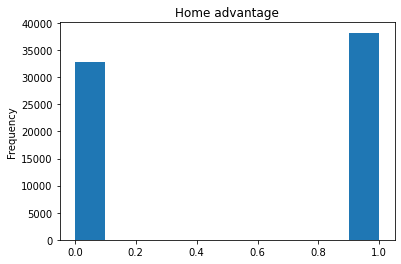

In [71]:
training_data['win'].plot.hist(
    title="Home advantage"
)

# ELO model

Let's review the math before we code it up. We describe the ELO system as MLE with online gradient descent. A similar but more detailed write-up is given in [this blog post](https://stmorse.github.io/journal/Elo.html).

## ELO Model

To each team $i$ we associate an ELO rating $\theta_i$. ELO ratings are the model's parameters. They represent relative strengths of teams.

Suppose team $i$ plays team $j$ and team $i$ is the home team. We label the game as follows:
$$ y_{i,j} = \left\{\begin{array} .1 & \text{if the home team wins, and}\\ 0& \text{if the home team loses.} \end{array}\right. $$
The first index in the subscript $i,j$ is always the home team.


The probability that the home team wins is modelled by a sigmoid function
$$ p_{i,j} = \sigma(a(\theta_i - \theta_j) + b) = \frac{1}{1 + e^{-a(\theta_i - \theta_j) - b}}.$$
The coefficients $a$ and $b$ are model hyperparameters. ELO uses a base 10 sigmoid function, which is just silly. I'm going to convert everything to base $e$ like a sane person.

In this simple version of the ELO model $b$ represents home advantage. If the historical probability the home team wins is $p$ then we can set 
$$ b = \ln \frac{p}{1 - p}$$
(set $\theta_i = \theta_j$ and solve for $b$).

## Learning

We learn our parameters using MLE and online gradient-descent. Let $\theta_i^t$ denote the rating of team $i$ at step $t$. Let $y_{i,j}^t$ denote the outcome of a game between team $i$ (home team) and team $j$ at step $t$. The log-likelihood of $y_{i,j}^t$ is 
$$L(y_{i,j}^t \mid \theta^t) =  \ln P(y_{i,j}^t \mid \theta^t) = y_{i,j}^t \ln p_{i,j}^t + (1 - y_{i,j}^t)\ln (1 - p_{i,j}^t) $$
where $p_{i,j}^t = \sigma(a (\theta_i^t - \theta_j^t) + b)$.

The gradient is
$$\nabla_\theta L(y_{i,j}^t \mid \theta^t) = y_{i,j}^t \nabla_\theta\ln p_{i,j}^t + (1 - y_{i,j}^t)\nabla_\theta\ln (1 - p_{i,j}^t)$$
$$ =  a y_{i,j}^t (1 - p_{i,j}^t)(\partial_{\theta_i} + \partial_{\theta_j}) + a(1 - y_{i,j}^t)p_{i,j}^t(\partial_{\theta_i} - \partial_{\theta_j}) $$
$$ = a(y_{i,j}^t - p_{i,j}^t)\frac{\partial}{\partial\theta_i} + a(p_{i,j}^t - y_{i,j}^t)\frac{\partial}{\partial\theta_j}.$$
This gradient makes sense in terms of the application too. If the result was anticipated with the current model parameters ($y_{i,j}^t \approx p_{i,j}^t$) then the gradient will be small. Conversely, if the result was not anticipated by the model parameters ($y_{i,j}^t - p_{i,j}^t \approx 1$) then the gradient will be large.  The rating of the winning team always increases and the rating of the losing team always decreases.

After such a game, the online gradient update is
$$ \theta_i^{t+1} = \theta_i^{t} + ka(y_{i,j}^t - p_{i,j}^t),$$
$$ \theta_j^{t+1} = \theta_j^{t} + ka(p_{i,j}^t - y_{i,j}^t).$$
The parameter $k$ is the learning rate, a hyperparameter to be tuned.

## Evaluation



In [74]:
# calculate the hyperparameter b from historical data
from math import log

p_home = training_data['win'].mean()
b = log(p_home / (1 - p_home))
p_home, b

(0.5378728193584693, 0.15178200099927933)

In [176]:
# create a dict of elo ratings
# we want to track their evolution over time
from datetime import timedelta

teams = training_data['Tm'].unique().tolist()
dates = pd.Series(training_data['Date'].unique()).sort_values()

game_records = training_data.to_records(index=False)
game_records[0]

('1990-04-09T00:00:00.000000000', 'TEX', 'TOR', 1)

In [219]:
from math import exp

def sigmoid(x):
    """Numberically stable sigmoid."""
    if x >= 0:
        return 1 / (1 + exp(-x))
    else:
        return exp(x) / (1 + exp(x))

starting_date = training_data['Date'].iloc[0]
initial_date = starting_date - timedelta(days=1)

initial_elo = 1500

k = 2000
a = log(10) / 400 # base change from usual elo
results = []

elo = {team: [(initial_date, initial_elo)] for team in teams}

for date, home, away, y in game_records:
    # get previous ratings
    (prev_home_date, home_rating), (prev_away_date, away_rating) = elo[home][-1], elo[away][-1]

    # compute probability that home team wins
    p = sigmoid(a * (home_rating - away_rating) + b)

    # log prediction accuracy
    if p > 0.5:
        results.append(y == 1)
    else:
        results.append(y == 0)

    # compute new ratings for both teams
    new_home_rating = home_rating + k * a * (y - p)
    new_away_rating = away_rating + k * a * (p - y)

    # log the results
    # in the case of double-headers overwrite the previous elo
    if date == prev_home_date:
        elo[home][-1] = (date, new_home_rating)
    else:
        elo[home].append((date, new_home_rating))

    if date == prev_away_date:
        elo[away][-1] = (date, new_away_rating)
    else:
        elo[away].append((date, new_away_rating))


In [229]:
# in terms of predicting who won games, the model is only slightly better than 
# a coin toss (or simply picking the home team)
from statistics import mean

mean([int(r) for r in results])

0.5578503095104108

In [221]:
elo_df = pd.DataFrame(index=dates)

for team, team_ratings in elo.items():
    s = pd.DataFrame(team_ratings, columns=['Date', team]).set_index('Date')
    elo_df = pd.merge(
        elo_df,
        s,
        how='left',
        left_index=True,
        right_index=True
    )

# elo_df = elo_df.ffill().fillna(initial_elo)

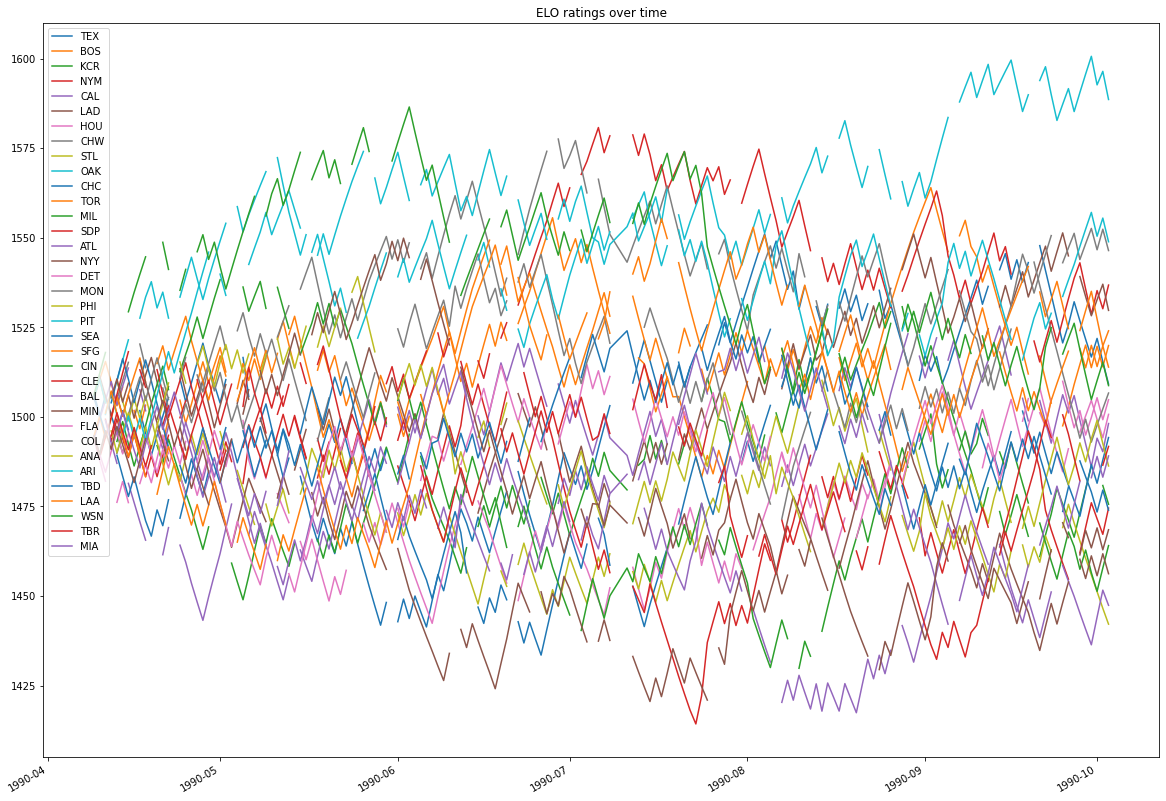

In [224]:
elo_df[elo_df.index.year == 1990].plot.line(title='ELO ratings over time', figsize=(20,15))

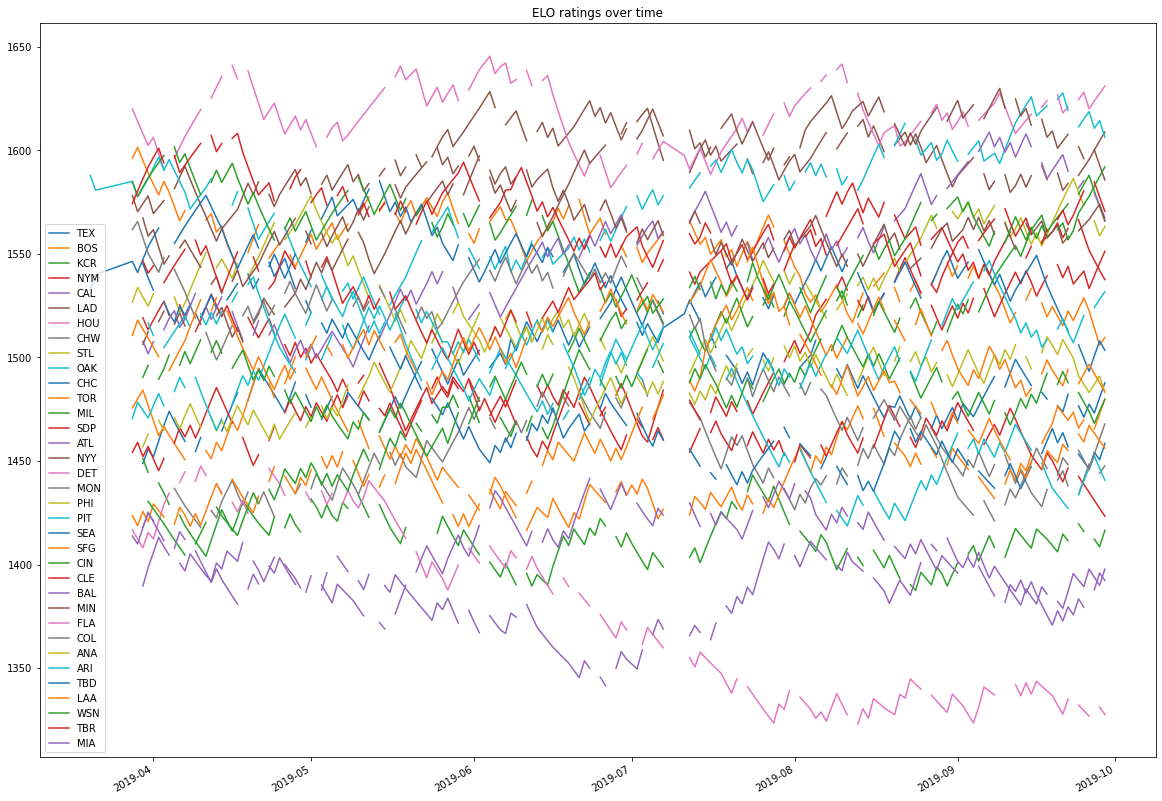

In [232]:
# the 2019 season
elo_df.loc[elo_df.index.year == 2019].plot.line(title='ELO ratings over time', figsize=(20,15))

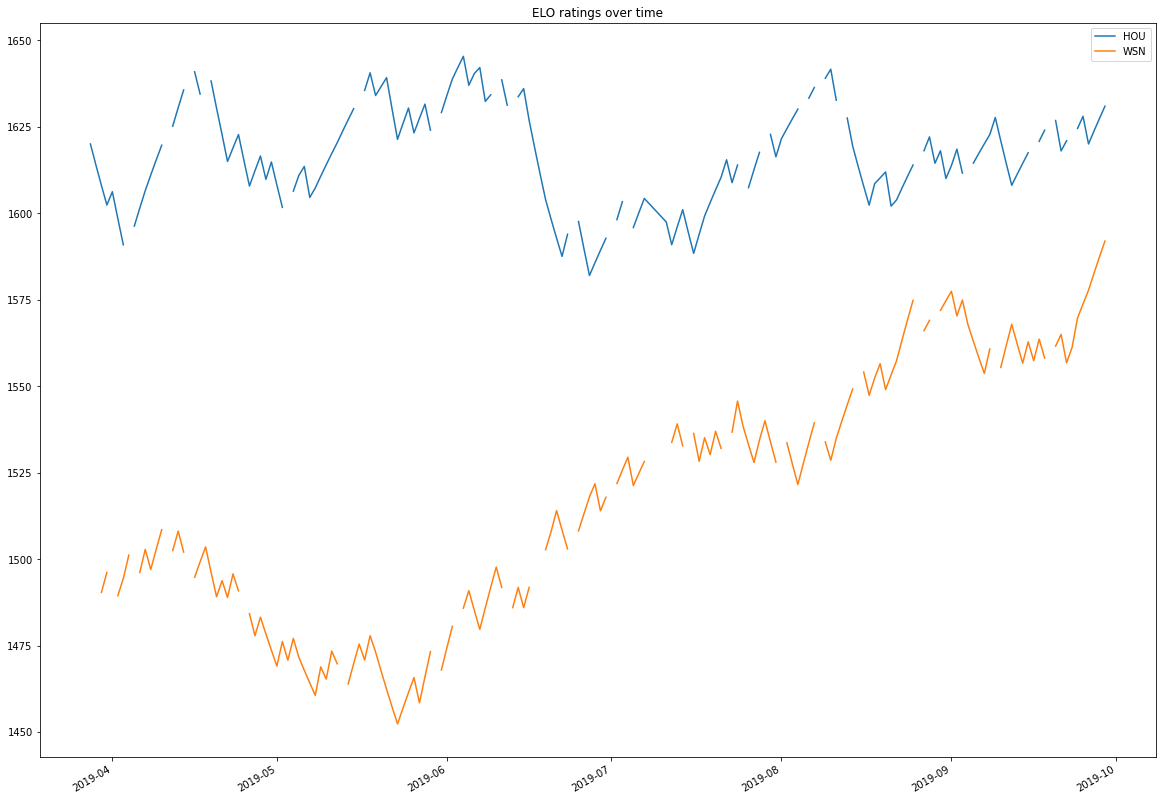

In [231]:
# the 2019 world series was between washington and houston
# houston had the highest elo at the end of the season
# while washington's was rising to the top
elo_df.loc[elo_df.index.year == 2019,['HOU', 'WSN']].plot.line(title='ELO ratings over time', figsize=(20,15))

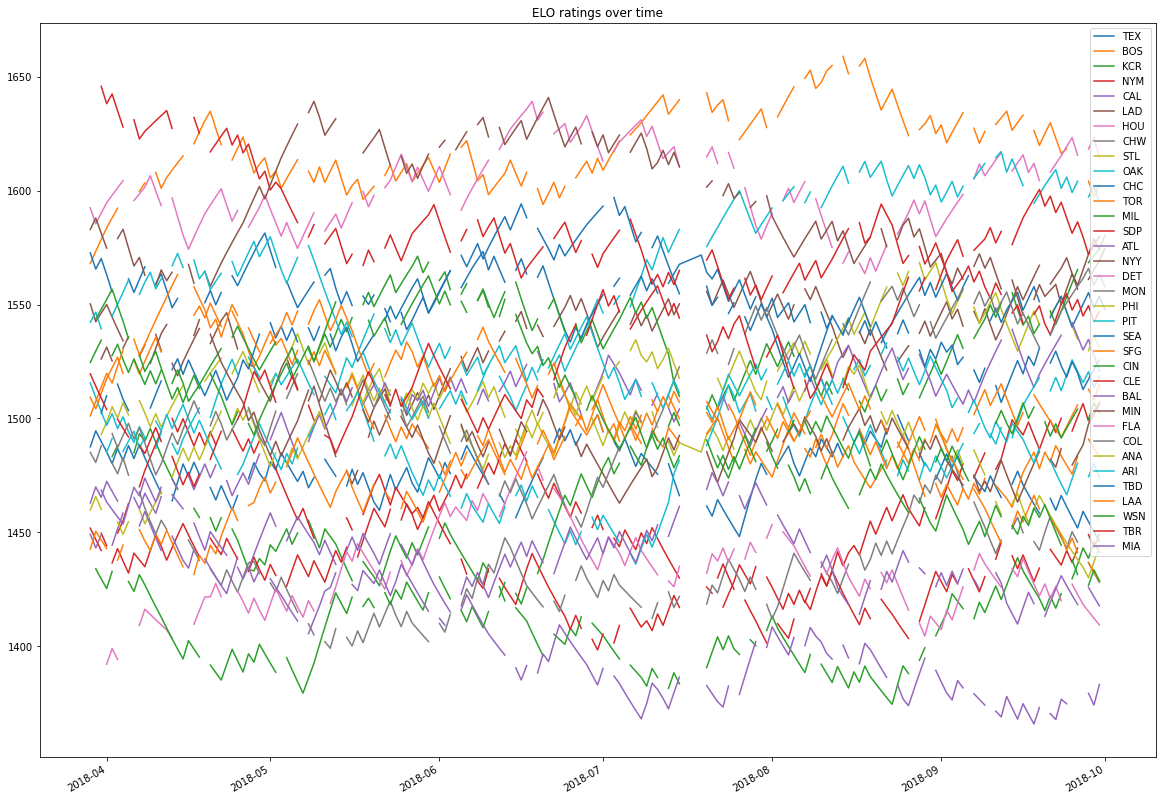

In [233]:
# 2018 season
elo_df[elo_df.index.year == 2018].plot.line(title='ELO ratings over time', figsize=(20,15))

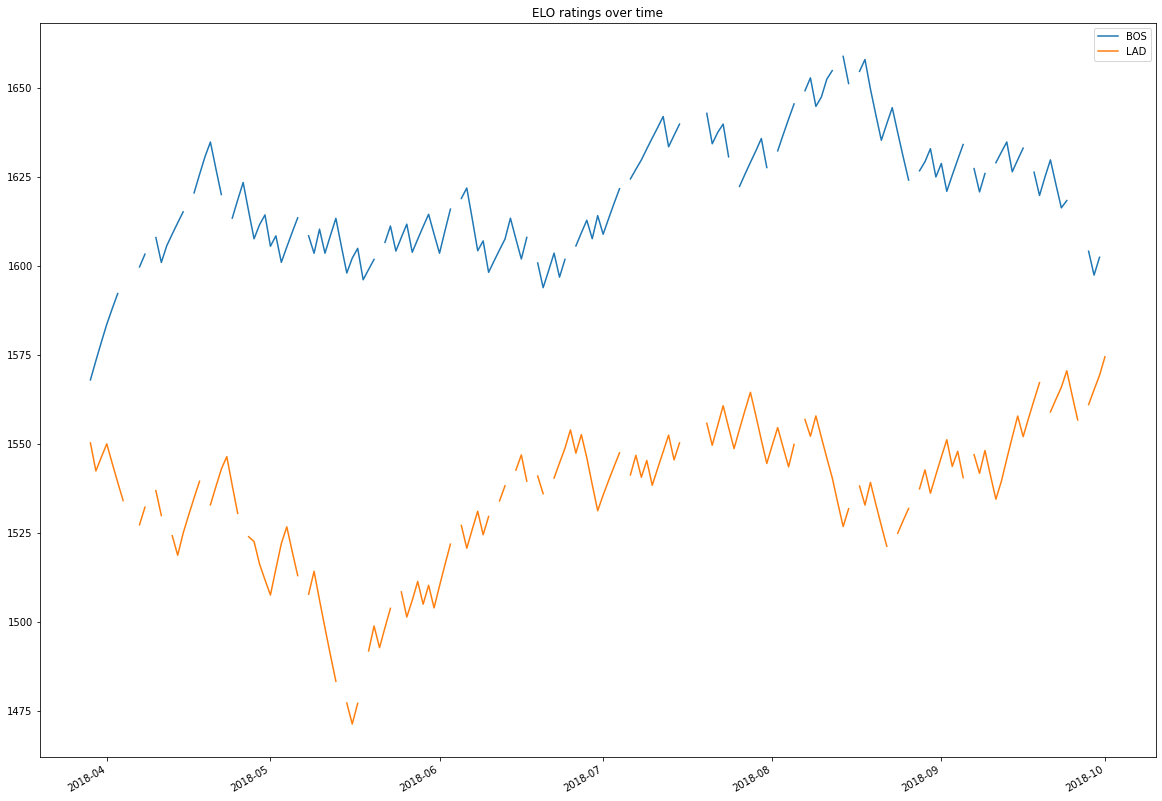

In [235]:
# the 2018 world series was between boston and the dodgers
elo_df.loc[elo_df.index.year == 2018, ['BOS', 'LAD']].plot.line(title='ELO ratings over time', figsize=(20,15))